# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #007fd4">Fake Job Detection using NLP</p>

##  <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Goal: Detecting Fake Job Postings posted in the different job portals</p>

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Import Libraries </p>

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
import re
import string 

from collections import Counter
from nltk.corpus import stopwords

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer,TfidfTransformer,CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report,
                             confusion_matrix,roc_curve, roc_auc_score, ConfusionMatrixDisplay)

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Load Data from the Source </p>

In [2]:
df_raw = pd.read_csv("preprocessed_combined_dataset.csv", sep = ",")
print(f"Raw Data Shape: {df_raw.shape}")
df_raw.head()

Raw Data Shape: (25923, 15)


,site,role,company_name,location,job_description,min_salary,max_salary,ratings,job_level,Search_Keywords,Search_Location,Job_Detail_Link,Post_Time,Current_Time,job_type
0,glassdoor,data analyst data entry,juristat,remote,juristat building innovative suite products ne...,30000.0,35000.0,NaN,entry_level,NaN,NaN,NaN,NaN,NaN,NaN
1,glassdoor,business systems analyst,distributed solar development,new york ny,join azad technology partners business systems...,130000.0,160000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,glassdoor,data analyst,haberfeld,lincoln ne,haberfeld align marketing products people sust...,54000.0,82000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,glassdoor,data analysis charlotte corporate location,genpak llc,charlotte nc,data analyst collect customer requirements det...,52000.0,81000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,glassdoor,data science graduate,hewlett packard enterprise,spring tx,data science graduate role designated edge mea...,57000.0,131000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df = df_raw.copy()

print(f"Shape: {df.shape}")

Shape: (25923, 15)


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Basic Data Exploration </p>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25923 entries, 0 to 25922
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   site             25923 non-null  object 
 1   role             25923 non-null  object 
 2   company_name     25768 non-null  object 
 3   location         25617 non-null  object 
 4   job_description  23537 non-null  object 
 5   min_salary       9174 non-null   float64
 6   max_salary       9174 non-null   float64
 7   ratings          3959 non-null   float64
 8   job_level        3917 non-null   object 
 9   Search_Keywords  1208 non-null   object 
 10  Search_Location  1208 non-null   object 
 11  Job_Detail_Link  1208 non-null   object 
 12  Post_Time        1208 non-null   object 
 13  Current_Time     1208 non-null   object 
 14  job_type         630 non-null    object 
dtypes: float64(3), object(12)
memory usage: 3.0+ MB


In [5]:
df.describe(include = "all")

,site,role,company_name,location,job_description,min_salary,max_salary,ratings,job_level,Search_Keywords,Search_Location,Job_Detail_Link,Post_Time,Current_Time,job_type
count,25923,25923,25768,25617,23537,9.174000e+03,9.174000e+03,3959.000000,3917,1208,1208,1208,1208,1208,630
unique,3,10804,10672,4114,21248,NaN,NaN,NaN,2,1,1,990,89,1,9
top,glassdoor,data analyst,tiktok,bengaluru,description eeoaffirmative action employer qua...,NaN,NaN,NaN,entry_level,data scientist,united states,https://www.indeed.com/rc/clk?jk=ab50cfa59689a...,posted posted 30+ days ago,2023-11-14,not available
freq,14393,2561,203,1273,41,NaN,NaN,NaN,2164,1208,1208,3,233,1208,437
mean,NaN,NaN,NaN,NaN,NaN,3.499170e+09,3.624817e+09,3.992069,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,4.536379e+10,4.595819e+10,0.450851,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.400000e+01,1.600000e+01,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,7.203000e+03,1.080400e+04,3.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,6.400000e+04,8.900000e+04,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,9.000000e+04,1.250000e+05,4.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df.describe(exclude="object")

,min_salary,max_salary,ratings
count,9.174000e+03,9.174000e+03,3959.000000
mean,3.499170e+09,3.624817e+09,3.992069
std,4.536379e+10,4.595819e+10,0.450851
min,1.400000e+01,1.600000e+01,1.000000
25%,7.203000e+03,1.080400e+04,3.800000
50%,6.400000e+04,8.900000e+04,4.000000
75%,9.000000e+04,1.250000e+05,4.200000
max,1.188475e+12,1.140456e+12,5.000000


In [7]:
df.describe(exclude=np.number)

,site,role,company_name,location,job_description,job_level,Search_Keywords,Search_Location,Job_Detail_Link,Post_Time,Current_Time,job_type
count,25923,25923,25768,25617,23537,3917,1208,1208,1208,1208,1208,630
unique,3,10804,10672,4114,21248,2,1,1,990,89,1,9
top,glassdoor,data analyst,tiktok,bengaluru,description eeoaffirmative action employer qua...,entry_level,data scientist,united states,https://www.indeed.com/rc/clk?jk=ab50cfa59689a...,posted posted 30+ days ago,2023-11-14,not available
freq,14393,2561,203,1273,41,2164,1208,1208,3,233,1208,437


There are many missing feature values, we will perform futhur checks

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;">Data Checks to perform </p>
 - Check Missing values
 - Check Duplicates
 - Check data type
 - Check the number of unique values of each column
 - Check statistics of data set
 - Check various categories present in the different categorical column
 
 #### Missing values

In [8]:
df.isnull().sum()

site                   0
role                   0
company_name         155
location             306
job_description     2386
min_salary         16749
max_salary         16749
ratings            21964
job_level          22006
Search_Keywords    24715
Search_Location    24715
Job_Detail_Link    24715
Post_Time          24715
Current_Time       24715
job_type           25293
dtype: int64

In [9]:
## Here we will check the percentage of nan values present in each feature
feature_na = [feature for feature in df.columns if df[feature].isnull().sum() > 0 ]

for feature in feature_na:
    print(feature, np.round(df[feature].isnull().mean() * 100,4), " % missing")

company_name 0.5979  % missing
location 1.1804  % missing
job_description 9.2042  % missing
min_salary 64.6106  % missing
max_salary 64.6106  % missing
ratings 84.7278  % missing
job_level 84.8899  % missing
Search_Keywords 95.34  % missing
Search_Location 95.34  % missing
Job_Detail_Link 95.34  % missing
Post_Time 95.34  % missing
Current_Time 95.34  % missing
job_type 97.5697  % missing


In [10]:
# Null valuse more than 10%
columns_with_null_values_total = (df.isnull().sum() / len(df)) * 100
columns_with_null_values_percentage = columns_with_null_values_total[columns_with_null_values_total > 10].sort_values(ascending=False)

columns_with_null_values_percentage

job_type           97.569726
Search_Keywords    95.340046
Search_Location    95.340046
Job_Detail_Link    95.340046
Post_Time          95.340046
Current_Time       95.340046
job_level          84.889866
ratings            84.727848
min_salary         64.610577
max_salary         64.610577
dtype: float64

<b>observation:</b> There are many missing feature values. There 8 features with ~85% values are null and 2 features with ~65% null.

The feature with 50% null values can be removed from the dataset

In [11]:
df.drop(columns_with_null_values_percentage.keys().tolist(),axis=1,inplace=True)

df.head()

,site,role,company_name,location,job_description
0,glassdoor,data analyst data entry,juristat,remote,juristat building innovative suite products ne...
1,glassdoor,business systems analyst,distributed solar development,new york ny,join azad technology partners business systems...
2,glassdoor,data analyst,haberfeld,lincoln ne,haberfeld align marketing products people sust...
3,glassdoor,data analysis charlotte corporate location,genpak llc,charlotte nc,data analyst collect customer requirements det...
4,glassdoor,data science graduate,hewlett packard enterprise,spring tx,data science graduate role designated edge mea...


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Duplicate Values Check </p>

In [12]:
df.duplicated().sum()

1089

In [13]:
print("***** Duplicate check Feature wise *****\n")

# Check Job description duplications
print("job_description: ", df["job_description"].duplicated().sum())



***** Duplicate check Feature wise *****

job_description:  4674


There are duplicated records, this has to taken care during preprocessing stage

In [14]:
#Sorting data according to text in ascending order
sorted_data=df.sort_values('job_description', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

sorted_data[sorted_data["job_description"].duplicated()]

,site,role,company_name,location,job_description
24716,monster,data scientist,dla piper,palo alto ca,_dla piper equal opportunity employer qualifie...
24590,monster,data scientist,dla piper,san diego ca,_dla piper equal opportunity employer qualifie...
23807,monster,data scientist,dla piper,atlanta ga,_dla piper equal opportunity employer qualifie...
24647,monster,data scientist,dla piper,san francisco ca,_dla piper equal opportunity employer qualifie...
24467,monster,data scientist,dla piper,houston tx,_dla piper equal opportunity employer qualifie...
...,...,...,...,...,...
19551,indeed,statistician intermediate,university michigan,thompson street ann arbor mi,NaN
19565,indeed,nlp natural language processing product manager,rex,austin tx,NaN
19567,indeed,artificial intelligence developer,intone networks,washington dc,NaN
19578,indeed,ai machine learning algorithms architect resea...,tachyum,santa clara ca,NaN


#### Check the Feature Uniqueness

In [15]:
for feature in df.columns:
    print('{}: Unique Count: {}\n {}\n'.format(feature, len(df[feature].unique()), df[feature].unique()))

site: Unique Count: 3
 ['glassdoor' 'indeed' 'monster']

role: Unique Count: 10804
 ['data analyst data entry' 'business systems analyst' 'data analyst' ...
 'software developer hybrid'
 'full stack software engineer remote eligible'
 'application developer hybrid']

company_name: Unique Count: 10673
 ['juristat' 'distributed solar development' 'haberfeld' ...
 'life cycle engineering' 'sentrilock llc' 'best corp']

location: Unique Count: 4115
 ['remote' 'new york ny' 'lincoln ne' ... 'rome ny' 'chaska mn'
 'socorro nm']

job_description: Unique Count: 21249
 ['juristat building innovative suite products need team create tools seeking highly motivated organized individual join data team data analyst team responsible acquiring analyzing complete accurate data available grow products inform business strategies particular team member responsible analyzing incoming legal documents realtime detect correct errors processing enter data source documents templates annotate legal documents prov

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Data preprocessing </p>

<b>Handle Missing Values</b>

In [16]:
df.isnull().sum()


site                  0
role                  0
company_name        155
location            306
job_description    2386
dtype: int64

In [17]:
# Fill na values with missing 

for feature in df.columns:
    if(df[feature].isnull().sum()>0):
        df[feature].fillna("missing", inplace=True)
        
df.isnull().sum()

site               0
role               0
company_name       0
location           0
job_description    0
dtype: int64

<b>Deduplication of data</b>

In [18]:
df.duplicated().sum()

1089

In [19]:
df.drop_duplicates(keep="first", inplace= True)
print("Shape: ", df.shape)

df.duplicated().sum()

Shape:  (24834, 5)


0

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Exploratory Data Analysis </p>

#### Description: Analyze the count of Charecters, Words, and Sentences in each segment

In [20]:
# No. of charecters in Job Description
df['desc_num_char'] = df['job_description'].apply(len)

# No. of of words in Job Description
df['desc_num_words'] = df['job_description'].apply(lambda x:len(nltk.word_tokenize(x)))

# No. of of sentences in Job Description
df['desc_num_sent'] = df['job_description'].apply(lambda x:len(nltk.sent_tokenize(x)))

df.head()

,site,role,company_name,location,job_description,desc_num_char,desc_num_words,desc_num_sent
0,glassdoor,data analyst data entry,juristat,remote,juristat building innovative suite products ne...,4309,542,1
1,glassdoor,business systems analyst,distributed solar development,new york ny,join azad technology partners business systems...,603,70,1
2,glassdoor,data analyst,haberfeld,lincoln ne,haberfeld align marketing products people sust...,2190,276,1
3,glassdoor,data analysis charlotte corporate location,genpak llc,charlotte nc,data analyst collect customer requirements det...,943,119,1
4,glassdoor,data science graduate,hewlett packard enterprise,spring tx,data science graduate role designated edge mea...,5391,675,1


In [21]:
df.describe(include=np.number)

,desc_num_char,desc_num_words,desc_num_sent
count,24834.000000,24834.000000,24834.0
mean,2207.003785,260.559274,1.0
std,2031.436212,237.638625,0.0
min,1.000000,1.000000,1.0
25%,576.000000,69.000000,1.0
50%,1731.000000,205.000000,1.0
75%,3457.000000,409.000000,1.0
max,31300.000000,3753.000000,1.0


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;"> Text preprocessing </p>

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative type

In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopWords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def preprocess(corpus):
    preprocessed = []
    for sentance in tqdm(corpus):
        #sentance = re.sub(r"http+", "", sentance)
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)    
        #sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopWords)
        #sentence = ' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords.words('english'))
        #preprocessed.append(sentance.strip())
        preprocessed.append(' '.join(token.lower() for token in nltk.word_tokenize(sentance) if token.lower() not in stopwords.words('english')))

    return preprocessed

In [36]:
df.sample(5)

,site,role,company_name,location,job_description,desc_num_char,desc_num_words,desc_num_sent
15069,indeed,data analyst,avalara,remote india,overview overview avalara working next generat...,3474,403,1
385,glassdoor,statistician data scientist,us patent trademark office,wallops island va,duties physical worksite position located alex...,20153,2320,1
14617,indeed,data analyst,plante moran,hybrid remote michigan,available,9,1,1
8088,glassdoor,data analytics associate accounting graduates,isla lipana co,makati city,qualifications undergraduate graduate degree a...,460,52,1
13223,glassdoor,technical business analyst ai temp,mineral,remote,us every small business journey different fill...,6650,806,1


In [24]:
%%time

df["desc_transformed"] = preprocess(df['job_description'].values)
#df["site_transformed"] = preprocess(df['site'].values)
#df["role_transformed"] = preprocess(df['role'].values)
#df["comp_transformed"] = preprocess(df['company_name'].values)
#df["loc_transformed"] = preprocess(df['location'].values)


df["desc_transformed"][:5]

100%|██████████████████████████████████████████████████████████████████████████| 24834/24834 [1:30:25<00:00,  4.58it/s]

CPU times: total: 1h 2min 2s
Wall time: 1h 30min 25s


0    juristat building innovative suite products ne...
1    join azad technology partners business systems...
2    haberfeld align marketing products people sust...
3    data analyst collect customer requirements det...
4    data science graduate role designated edge mea...
Name: desc_transformed, dtype: object

In [25]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

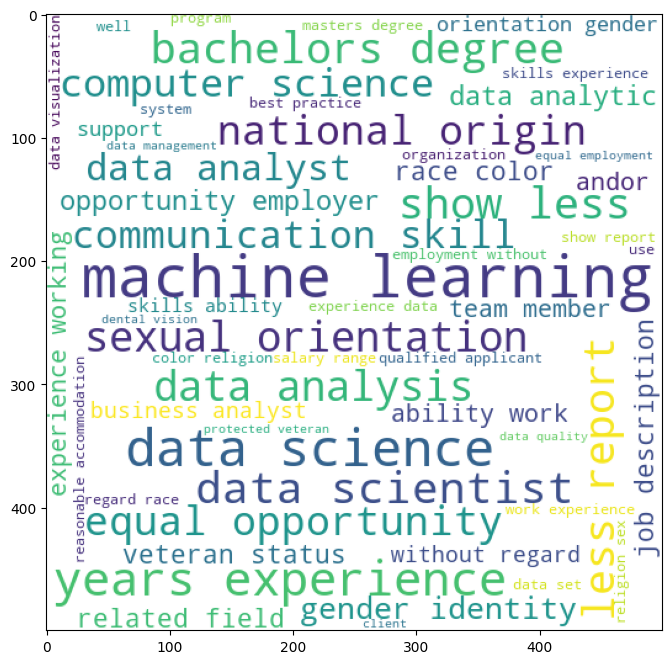

In [26]:
desc_wc = wc.generate(df['desc_transformed'].str.cat(sep=" "))

plt.figure(figsize=(13,8))
plt.imshow(desc_wc)

<b>Extract the Opinin from the Lexicon Lib</b>

In [47]:
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\smsub\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


True

In [48]:
# Load positive and negative words from opinion_lexicon
positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

In [49]:
def analyze_sentiment(text):
    words = word_tokenize(text.lower())
    sentiment_score = sum([1 if word in positive_words else -1 if word in negative_words else 0 for word in words])
    return "real" if sentiment_score > 0 else "fake"

In [50]:
df['fraudulent'] = df['desc_transformed'].apply(analyze_sentiment)

In [51]:
df['fraudulent'].value_counts()

fraudulent
real    21508
fake     3326
Name: count, dtype: int64

<b>Fraudulent wise WordCloud</b>

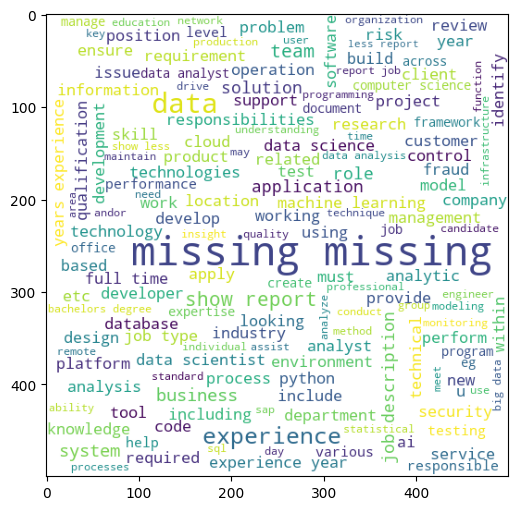

In [52]:
fraud_wc = wc.generate(df[df['fraudulent'] == "fake"]['desc_transformed'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(fraud_wc)

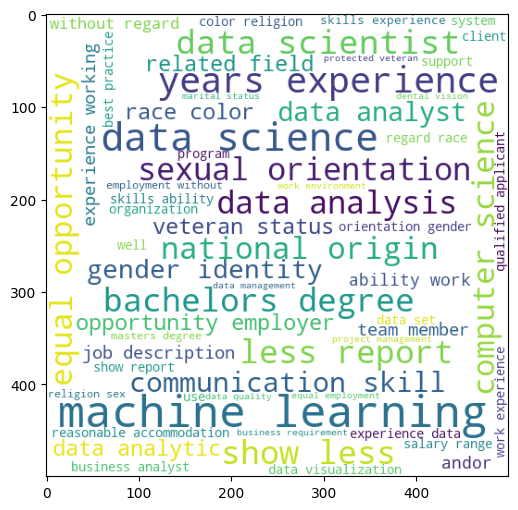

In [53]:
fraud_wc = wc.generate(df[df['fraudulent'] == "real"]['desc_transformed'].str.cat(sep=" "))

plt.figure(figsize=(15,6))
plt.imshow(fraud_wc)

In [54]:
fraud_corpus = []
for msg in df[df['fraudulent'] == "fake"]['desc_transformed'].tolist():
    for word in msg.split():
        fraud_corpus.append(word)
        
len(fraud_corpus)

66265

In [55]:
faith_corpus = []
for msg in df[df['fraudulent'] == "real"]['desc_transformed'].tolist():
    for word in msg.split():
        faith_corpus.append(word)
        
len(faith_corpus)

6400633

<b>Fake - 30 Most used words</b>

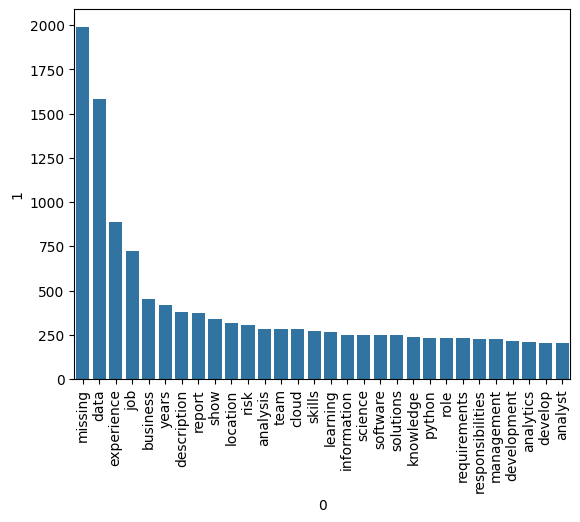

In [56]:
sns.barplot(x = pd.DataFrame(Counter(fraud_corpus).most_common(30))[0],
            y = pd.DataFrame(Counter(fraud_corpus).most_common(30))[1]
           )
plt.xticks(rotation='vertical')
plt.show()

<b>Real - 30 Most used words</b>

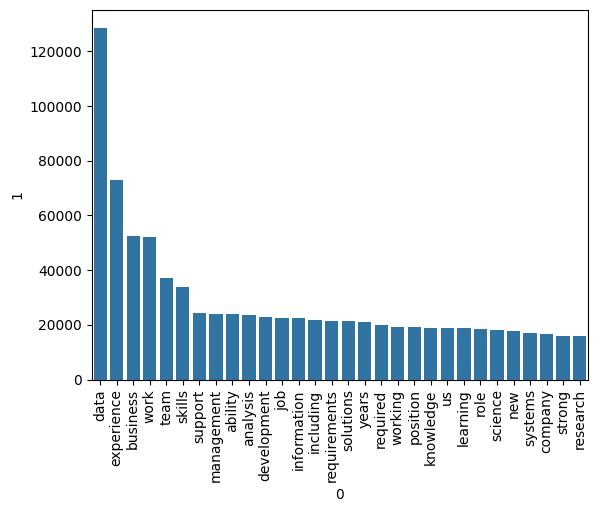

In [57]:
sns.barplot(x = pd.DataFrame(Counter(faith_corpus).most_common(30))[0],
            y = pd.DataFrame(Counter(faith_corpus).most_common(30))[1]
           )
plt.xticks(rotation='vertical')
plt.show()

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;">Featurization </p>

<b>BOW - Bag of words</b>
Count Vectorization: This is a simpler vectorization technique which relies on frequency of occurence of a particular term in a document or corpus.

In [58]:
preprocessed_desc = df["desc_transformed"]

In [59]:
%%time
##BoW
count_vect = CountVectorizer() 
count_vect.fit(preprocessed_desc)

print("some feature names ", count_vect.get_feature_names_out()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_desc)

print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa' 'aaa' 'aaahc' 'aaai' 'aaaiijcai' 'aaaip' 'aaarl' 'aaas'
 'aaassociate' 'aabs']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (24834, 81379)
the number of unique words  81379
CPU times: total: 10.1 s
Wall time: 10.1 s


<b>Bi-Grams and n-Grams</b>

In [60]:
%%time
#bi-gram, tri-gram and n-gram


count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_desc)

print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text BOW vectorizer  (24834, 5000)
the number of unique words including both unigrams and bigrams  5000
CPU times: total: 19.1 s
Wall time: 19.3 s


<b>TF-IDF</b><br/>

TF-IDF Vectorization: This works by applying a logarithmic term to inverse document frequency (IDF) part other than determining the "TF" or term freqency part

In [61]:
%%time

tf_idf_vect = TfidfVectorizer(ngram_range=(1,3), max_features=3000)
tf_idf_vect.fit(preprocessed_desc)

print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names_out()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_desc)

print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ab' 'abilities' 'ability' 'ability communicate' 'ability effectively'
 'ability manage' 'ability work' 'ability work independently' 'able'
 'able work']
the type of count vectorizer  <class 'scipy.sparse._csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (24834, 3000)
the number of unique words including both unigrams and bigrams  3000
CPU times: total: 58.1 s
Wall time: 58.6 s


In [62]:
print("TF_IDF Shape: ", final_tf_idf.shape)

TF_IDF Shape:  (24834, 3000)


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#007fd4; font-size:120%; text-align:left;padding: 0px;">Model Building </p>

In [63]:
df['fraudulent'] = df['fraudulent'].map({"real": 0, "fake":1})

df['fraudulent'].value_counts()

fraudulent
0    21508
1     3326
Name: count, dtype: int64

In [64]:
X = final_tf_idf.toarray()
y = df['fraudulent'].values

print("X: ", X.shape)
print("Y: ", y.shape)

X:  (24834, 3000)
Y:  (24834,)


In [67]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [68]:
modelName = []
trainaccScore = []
testaccScore = []
aucrocScore = []
precScore = []
recallScore = []

def computePerformance(X_train, X_test, y_train, y_test, model, modelname):

    train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Training test Accuracy
    accuracy_train = accuracy_score(y_train,train_pred)
    print("Train Accuracy:", accuracy_train)

    # Test test Accuracy
    accuracy_test = accuracy_score(y_test,y_pred)
    print("Test Accuracy:", accuracy_test)
    
    # Precision Score
    precisionScore = precision_score(y_test,y_pred)
    print("Precision Score:", precisionScore)
    
    # Recall Score
    recScore = recall_score(y_test,y_pred)
    print("Recall Score:", recScore)
    
    # F1 Score
    f1Score = f1_score(y_test,y_pred)
    print("F1 Score:", f1Score)


    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\n****** Confusion Matrix *****")
    print(cm)

    # Classification report
    print("\n****** Classification Report *****")
    report = classification_report(y_test, y_pred, target_names=["Fake","Real"])
    print(report)
     

    # AUC ROC Curve
    preds = model.predict_proba(X_test)[:,1]
    rocaucScore = roc_auc_score(y_test, preds)
    print("\n AUC_ROC Score:", rocaucScore)

    modelName.append(modelname)
    trainaccScore.append(accuracy_train)
    testaccScore.append(accuracy_test)
    aucrocScore.append(rocaucScore)
    precScore.append(precisionScore)
    recallScore.append(recScore)

#### Base Models 
<b>Gaussian NB</b>

In [69]:
model_gNB =  GaussianNB()
model_gNB.fit(X_train, y_train)

computePerformance(X_train, X_test, y_train, y_test, model_gNB,"GaussianNB")

Train Accuracy: 0.9629033069914934
Test Accuracy: 0.954298369236964
Precision Score: 0.8166189111747851
Recall Score: 0.852017937219731
F1 Score: 0.8339429407461595

****** Confusion Matrix *****
[[4170  128]
 [  99  570]]

****** Classification Report *****
              precision    recall  f1-score   support

       Fraud       0.98      0.97      0.97      4298
       Faith       0.82      0.85      0.83       669

    accuracy                           0.95      4967
   macro avg       0.90      0.91      0.90      4967
weighted avg       0.96      0.95      0.95      4967


 AUC_ROC Score: 0.9179491138854865


#### LogisticRegression

In [70]:
model_lr = LogisticRegression()

model_lr.fit(X_train, y_train)

computePerformance(X_train, X_test, y_train, y_test, model_lr,"LogisticRegression")

Train Accuracy: 0.9716615493028641
Test Accuracy: 0.9685927118985302
Precision Score: 0.9923224568138196
Recall Score: 0.772795216741405
F1 Score: 0.8689075630252101

****** Confusion Matrix *****
[[4294    4]
 [ 152  517]]

****** Classification Report *****
              precision    recall  f1-score   support

       Fraud       0.97      1.00      0.98      4298
       Faith       0.99      0.77      0.87       669

    accuracy                           0.97      4967
   macro avg       0.98      0.89      0.93      4967
weighted avg       0.97      0.97      0.97      4967


 AUC_ROC Score: 0.9903935574025113


In [71]:
knc = KNeighborsClassifier()
gNB =  GaussianNB()
mnb = MultinomialNB()
bnb =  BernoulliNB()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
dtc = DecisionTreeClassifier(max_depth=5)
svc = SVC(kernel='sigmoid', gamma=1.0)
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

clfs = {    
    'KN' : knc, 
    'gNB': gNB,
    'mNB': mnb, 
    'bNB': bnb,
    'LR': lrc, 
    'SVC' : svc,
    'DT': dtc,    
    'RF': rfc,      
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb,
    'AdaBoost': abc
}

In [72]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    f1score = f1_score(y_test,y_pred,average='weighted')
    
    return accuracy,precision,recall,f1score

In [73]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision,current_recall,current_f1score = train_classifier(clf, X_train, y_train,X_test,y_test)
        
    print(f"{name} Accuracy: {current_accuracy} Precision: {current_precision} Recall: {current_recall} F1Score: {current_f1score}")
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    recall_scores.append(current_recall)
    f1_scores.append(current_f1score)

  File "C:\Users\smsub\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


KN Accuracy: 0.38232333400442925 Precision: 0.17624831309041836 Recall: 0.976083707025411 F1Score: 0.42804942598153867
gNB Accuracy: 0.954298369236964 Precision: 0.8166189111747851 Recall: 0.852017937219731 F1Score: 0.9547057822667565
mNB Accuracy: 0.9547010267767264 Precision: 1.0 Recall: 0.6636771300448431 F1Score: 0.9507000171149056
bNB Accuracy: 0.7729011475739883 Precision: 0.36937962435970406 Recall: 0.9701046337817638 F1Score: 0.8073705250145162
LR Accuracy: 0.9750352325347292 Precision: 0.9690189328743546 Recall: 0.8415545590433483 F1Score: 0.9742829639415628
SVC Accuracy: 0.9716126434467486 Precision: 0.9731182795698925 Recall: 0.8116591928251121 F1Score: 0.9705095649300283
DT Accuracy: 0.9520837527682706 Precision: 0.9736263736263736 Recall: 0.6621823617339312 F1Score: 0.9481042873480441
RF Accuracy: 0.9742299174552044 Precision: 0.9873873873873874 Recall: 0.8191330343796711 F1Score: 0.9731984847092404
BgC Accuracy: 0.9728206160660359 Precision: 0.9587628865979382 Recall: 0.8

In [74]:
modelScore = pd.DataFrame({'Model':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores,
                               'Recall':recall_scores,'F1Score':f1_scores}
                             ).sort_values(['F1Score','Precision','Recall'],ascending=False)

modelScore

,Model,Accuracy,Precision,Recall,F1Score
11,xgb,0.977451,0.952846,0.875934,0.977047
4,LR,0.975035,0.969019,0.841555,0.974283
9,ETC,0.974633,0.990958,0.819133,0.973597
7,RF,0.974230,0.987387,0.819133,0.973198
8,BgC,0.972821,0.958763,0.834081,0.972012
5,SVC,0.971613,0.973118,0.811659,0.970510
12,AdaBoost,0.966579,0.899841,0.846039,0.966142
1,gNB,0.954298,0.816619,0.852018,0.954706
10,GBDT,0.957520,0.985169,0.695067,0.954328
2,mNB,0.954701,1.000000,0.663677,0.950700
